In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import pickle
import csv

%matplotlib inline

In [2]:
version = torch.__version__
device = "cuda:0" if torch.cuda.is_available() else "cpu"
image_dim_size = 28
cl_filter_size = 9
cl_num_filters = 256
cl_input_channels = 1
cl_stride = 1
cl_output_dim = int((image_dim_size - cl_filter_size + 1) / cl_stride)

In [3]:
pc_input_size = cl_output_dim # added for pedagogical purpose
pc_filter_size = 9
pc_stride = 2
pc_caps_dim = 8
pc_input_channels = cl_num_filters # added for pedagogical purpose
pc_num_caps_channels = 32 
pc_output_dim = int((pc_input_size - pc_filter_size + 1) / pc_stride) # added for pedagogical purpose

# Digit caps
dc_num_caps = 10
dc_caps_dim = 16

# Routing parameters
iterations = 3

# Regularisation
reconst_loss_scale = 0.0005 * image_dim_size**2

In [4]:
class CapsModel(nn.Module):
    def __init__(self, 
                 cl_input_channels, 
                 cl_num_filters, 
                 cl_filter_size, 
                 cl_stride,
                 pc_input_channels,
                 pc_num_caps_channels,
                 pc_caps_dim,
                 pc_filter_size,
                 pc_stride,
                 image_dim_size,
                 dc_num_caps,
                 dc_caps_dim,
                 iterations,
                 reconst_loss_scale):
        
        super(CapsModel, self).__init__()
        
        self.iterations = iterations
        self.pc_caps_dim = pc_caps_dim 
        self.reconst_loss_scale = reconst_loss_scale
        
        self.conv_layer_1 = nn.Conv2d(in_channels=cl_input_channels,
                              out_channels=cl_num_filters,
                              kernel_size=cl_filter_size, 
                              stride=cl_stride)
        
        self.conv_layer_2 = nn.Conv2d(in_channels=pc_input_channels,
                                     out_channels=pc_num_caps_channels * pc_caps_dim,
                                     kernel_size=pc_filter_size,
                                     stride=pc_stride)
        
        cl_output_dim = int((image_dim_size - cl_filter_size + 1) / cl_stride)
        pc_output_dim = int((cl_output_dim - pc_filter_size + 1) / pc_stride)
        self.pc_num_caps = pc_output_dim*pc_output_dim*pc_num_caps_channels
        self.W = nn.Parameter(0.01 * torch.randn(1,
                                            self.pc_num_caps, # We have one weight matrix for each pair of capsules in
                                            dc_num_caps,      # primary capsules layer and digit caps layer.
                                            dc_caps_dim,      # Each such matrix has a dimension of 
                                            pc_caps_dim))
        
        self.reconst_loss = nn.MSELoss()
        
    def forward(self, x):
        c = F.relu(self.conv_layer_1(x))
        u = self.conv_layer_2(c)
        u_sliced = self.squash( u.permute(0,2,3,1).contiguous()\
                               .view(c.shape[0], -1, self.pc_caps_dim)).unsqueeze(-1).unsqueeze(2)
        u_hat = torch.matmul(self.W, u_sliced).squeeze(4)  # Removing last dummy dimension, not needed anymore
        v = self.routing(u_hat).squeeze(1)
        return v
    
    def routing(self, u_hat):
        b = torch.zeros_like( u_hat )  #b_ij parameters have the same dimension as u_hat
        u_hat_routing = u_hat.detach()
        for i in range(self.iterations):
            c = F.softmax(b, dim=2)   
            if i==(self.iterations-1):
                s = (c*u_hat).sum(1, keepdim=True)
            else:
                s = (c*u_hat_routing).sum(1, keepdim=True)
            v = self.squash(s)
            if i < self.iterations - 1: b = (b + (u_hat_routing*v).sum(3, keepdim=True))
        return v
            
    def squash(self, s):
        s_norm = s.norm(dim=-1, keepdim=True)
        v = s_norm / (1. + s_norm**2) * s
        return v    
    
    # Defining loss function
    def loss(self, T, v, x_true, x_reconstructed, lambda_param=0.5, m_plus=0.9, m_minus=0.1):     
        v_norm = v.norm(dim=2, keepdim=False)
        return (T*F.relu(m_plus - v_norm)**2 + lambda_param * (1-T)*F.relu(v_norm - m_minus)**2).sum(1).mean() \
                +self.reconst_loss_scale * self.reconst_loss(x_reconstructed, x_true.view(x_true.shape[0],-1))

In [5]:
class Decoder(nn.Module):
    def __init__(self, dc_caps_dim, dc_num_caps, image_dim_size):
        super(Decoder, self).__init__()
        self.dc_num_caps = dc_num_caps
        self.network = nn.Sequential(
            nn.Linear(dc_caps_dim * dc_num_caps, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, image_dim_size**2),
            nn.Sigmoid()
        )

        
    def forward(self, v, y_ohe):       
        return self.network( (y_ohe[:,:,None] * v).view(v.shape[0], -1) )

In [6]:
model = CapsModel(cl_input_channels, 
                 cl_num_filters, 
                 cl_filter_size, 
                 cl_stride,
                 pc_input_channels,
                 pc_num_caps_channels,
                 pc_caps_dim,
                 pc_filter_size,
                 pc_stride,
                 image_dim_size,
                 dc_num_caps,
                 dc_caps_dim, 
                 iterations,
                 reconst_loss_scale).to(device)
decoder = Decoder(dc_caps_dim, dc_num_caps, image_dim_size,).to(device)

In [7]:
optimiser = torch.optim.Adam(list(model.parameters()) + list(decoder.parameters()), lr=0.001)
lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.96**(1/2000.))
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model) + count_parameters(decoder)

8215568

In [8]:
loss_train = 10     # Initialize with arbitrary high value
num_epoch=10

losses_train = []
losses_val = []

errors_train = []
errors_val = []

min_error = np.inf
error_rate_batch = 1.

train_sample_built = False

logfile = open('log_'+version+'.csv', 'w')
logwriter = csv.DictWriter(logfile, fieldnames=['epoch', 'train_loss', 'val_loss', 'val_error'])
logwriter.writeheader()

37

In [9]:
#!wget www.di.ens.fr/~lelarge/FashionMNIST.tar.gz
#!tar -zxvf FashionMNIST.tar.gz
def error_rate_calc(v_list, y_labels_list):
    v = torch.cat(v_list)
    y_labels = torch.cat(y_labels_list).cuda()
    _, y_pred = v.norm(p=2, dim=2).max(dim=1)
    return float( 1 - (y_pred == y_labels).float().mean() )

def load_mnist(path='./', download=True, batch_size=128, shift_pixels=2):
    kwargs = {'num_workers': 2, 'pin_memory': True}
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(path, 
                       train=True, 
                       download=download,
                       transform=transforms.Compose([transforms.RandomCrop(size=28, padding=shift_pixels),
                                                     transforms.ToTensor()])),
        batch_size=256, 
        shuffle=True, 
        **kwargs)
    
    
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(path, 
                       train=False, 
                       download=download,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, 
        shuffle=True, 
        **kwargs)

    return train_loader, test_loader

train_loader, test_loader = load_mnist()

In [10]:
epoch = 0
while epoch < num_epoch:
    loss_train = 0
    with tqdm(total=len(train_loader)) as pbar:
        model.train()
        for x_train, y_train in train_loader:
          
            # Model training
            x_train = Variable(x_train.cuda()).to(device).float()
            y_train_ohe =  Variable(F.one_hot(y_train,10).float()).to(device)
            
            v = model(x_train) 
            
            # Calculate loss and do backward step
            loss = model.loss(y_train_ohe, v, x_train, decoder(v, y_train_ohe ) ) 
            model.zero_grad()
            decoder.zero_grad()
            loss.backward()
            optimiser.step()  
            
            # Calculates error rate on batch
            _, y_pred_batch = v.norm(p=2, dim=2).max(dim=1)
            error_rate_batch = error_rate_batch*0.9 + float( 1 - (y_pred_batch.data == y_train.cuda()).float().mean() ) * 0.1
            
            # Performance reporting 
            loss_train += loss.item()
            pbar.set_postfix(error_rate_batch=error_rate_batch)
            pbar.update(1)
            lr_decay.step()
    
    loss_train /= len(train_loader)
    
    # Calculates error rate and loss funciton on validation set
    v_val_list = []
    loss_test_list = []
    y_test_list = []
    model.eval()
    for x_test, y_test in test_loader:
        x_test = Variable(x_test.cuda()).to(device).float()
        y_test_ohe = Variable(F.one_hot(y_test,10)).to(device).float()
        
        v_val_batch = model(x_test)
        v_val_list.append(v_val_batch.data)
        loss_test_list.append( model.loss(y_test_ohe, 
                                          v_val_batch, 
                                          x_test, 
                                          decoder(v_val_batch, y_test_ohe)).item())
        y_test_list.append(y_test)
    
    # Error rate: 
    v_val = torch.cat(v_val_list)
    y_test_labels = torch.cat(y_test_list).cuda()
    _, y_pred_test = v_val.norm(p=2, dim=2).max(dim=1)
    error_rate = float( 1 - (y_pred_test == y_test_labels).float().mean() )
    
    # Calculates loss function on validation set
    loss_val = np.mean(loss_test_list)
 
    # Stores loss values for train and validation
    losses_train.append(loss_train)
    errors_train.append(error_rate_batch)
    losses_val.append(loss_val)
    errors_val.append(error_rate)
    
    # Stores model
    if error_rate<min_error: 
        torch.save(model.state_dict(), 'model_'+version+'.pickle')
        torch.save(decoder.state_dict(), 'decode_'+version+'.pickle')
        min_error = error_rate
        
    # Print and log some results
    print("epoch:{}\t loss_train:{:.4f}\t loss_val:{:.4f}\t error_rate:{:.4f}\t learning_rate:{:.3f}".format(epoch, loss_train, loss_val, error_rate, lr_decay.get_lr()[0]))
    logwriter.writerow(dict(epoch=epoch, train_loss=loss_train,
                                val_loss=loss_val, val_error=error_rate))
    
    epoch += 1

100%|██████████| 235/235 [00:39<00:00,  5.91it/s, error_rate_batch=0.191]
/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:448: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|          | 0/235 [00:00<?, ?it/s]

epoch:0	 loss_train:0.2407	 loss_val:0.1529	 error_rate:0.1841	 learning_rate:0.001


  0%|          | 0/235 [00:00<?, ?it/s]

epoch:1	 loss_train:0.1399	 loss_val:0.1348	 error_rate:0.1683	 learning_rate:0.001


  0%|          | 0/235 [00:00<?, ?it/s]

epoch:2	 loss_train:0.1200	 loss_val:0.1136	 error_rate:0.1363	 learning_rate:0.001


  0%|          | 0/235 [00:00<?, ?it/s]

epoch:4	 loss_train:0.1041	 loss_val:0.1022	 error_rate:0.1194	 learning_rate:0.001


  0%|          | 0/235 [00:00<?, ?it/s]

epoch:5	 loss_train:0.0996	 loss_val:0.0970	 error_rate:0.1135	 learning_rate:0.001


  0%|          | 0/235 [00:00<?, ?it/s]

epoch:6	 loss_train:0.0954	 loss_val:0.0928	 error_rate:0.1081	 learning_rate:0.001


  0%|          | 0/235 [00:00<?, ?it/s]

epoch:7	 loss_train:0.0926	 loss_val:0.0912	 error_rate:0.1093	 learning_rate:0.001


  0%|          | 0/235 [00:00<?, ?it/s]

epoch:8	 loss_train:0.0885	 loss_val:0.0924	 error_rate:0.1037	 learning_rate:0.001


100%|██████████| 235/235 [00:40<00:00,  5.78it/s, error_rate_batch=0.0972]


epoch:9	 loss_train:0.0872	 loss_val:0.0903	 error_rate:0.1056	 learning_rate:0.001


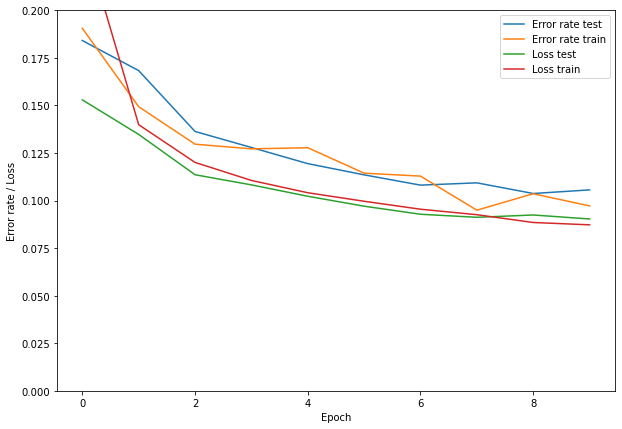

In [13]:
plt.figure(figsize=(10,7))
plt.plot(errors_val, label='Error rate test')
plt.plot(errors_train, label='Error rate train')
plt.plot(losses_val, label='Loss test')
plt.plot(losses_train, label='Loss train')
plt.ylabel('Error rate / Loss')
plt.xlabel('Epoch')
plt.ylim((0,0.2))

plt.legend()
plt.show()

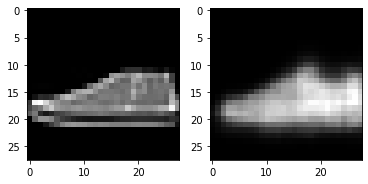

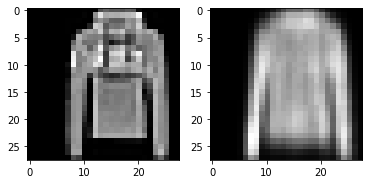

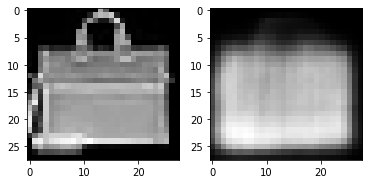

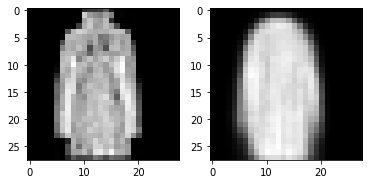

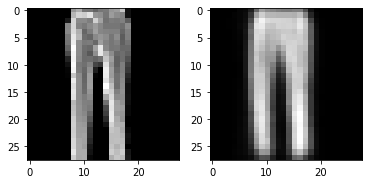

In [14]:
for i in range(5):
    caps = model(x_train[i].unsqueeze(0))
    recon = decoder(caps,y_train_ohe[i].unsqueeze(0)).detach().cpu().view(28,28)
    plt.subplot(1,2,1)
    plt.imshow(x_train[i].view(28,28).cpu(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(recon, 
               cmap='gray')
    plt.show()